# **Final Project - Signal Digital Processing**

**Design of a Vehicle Sound Classification System Based on Spectral Analysis Using Fast Fourier Transform (FFT) and MFCC Feature Extraction**

- Abdullah Al-Firdaus Nuzula (24031554008)
- Rizki Piji Fathoni (24031554029)

## **Installation and Import Library**

In [1]:
import kagglehub
path = kagglehub.dataset_download("janboubiabderrahim/vehicle-sounds-dataset")


100%|██████████| 6.90G/6.90G [01:19<00:00, 92.9MB/s]

Extracting files...


In [2]:
import shutil
shutil.copytree(path, "/content/vehicle_sound", dirs_exist_ok=True)
general_path = "/content/vehicle_sound"

In [3]:
!pip install numpy pandas matplotlib seaborn librosa scipy scikit-learn

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import librosa
import librosa.display
import scipy.signal as sig
from scipy.fft import fft, fftfreq
from google.colab import files
from scipy.io import wavfile
import IPython.display as ipd
from collections import defaultdict
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

## **Load Data**

In [5]:
DATASET_PATH = r"vehicle_sound"

if os.path.exists(DATASET_PATH):
    print(f"Path found: {DATASET_PATH}")
    print("Main folder:", os.listdir(DATASET_PATH))
else:
    print("ERROR: Path not found")

Path found: vehicle_sound
Main folder: ['Helicopter', 'Airplane', 'Cars', 'Train', 'bus', 'Motocycles', 'Bics', 'Truck']


In [6]:
file_paths = []
labels = []

for label in os.listdir(DATASET_PATH):
    class_dir = os.path.join(DATASET_PATH, label)

    if os.path.isdir(class_dir):
        print(f"Scanning the class: {label}...")
        for filename in os.listdir(class_dir):
            if filename.endswith(('.wav', '.mp3')):
                file_path = os.path.join(class_dir, filename)
                file_paths.append(file_path)
                labels.append(label)

df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

print("\n--- Data Loading Completed ---")
print(f"Total audio files found: {len(df)}")
print(f"Number of Classes: {df['label'].nunique()}")
print("\nExample of the first 5 data points:")
display(df)

Scanning the class: Helicopter...
Scanning the class: Airplane...
Scanning the class: Cars...
Scanning the class: Train...
Scanning the class: bus...
Scanning the class: Motocycles...
Scanning the class: Bics...
Scanning the class: Truck...

--- Data Loading Completed ---
Total audio files found: 9448
Number of Classes: 8

Example of the first 5 data points:


file_path       label
0     vehicle_sound/Helicopter/Best_Helicopter_Sound...  Helicopter
1     vehicle_sound/Helicopter/Best_Helicopter_Sound...  Helicopter
2     vehicle_sound/Helicopter/Best_Helicopter_Sound...  Helicopter
3     vehicle_sound/Helicopter/25th_Huey_Helicopter_...  Helicopter
4     vehicle_sound/Helicopter/Best_Helicopter_Sound...  Helicopter
...                                                 ...         ...
9443  vehicle_sound/Truck/mixkit_truck_slowing_down_...       Truck
9444  vehicle_sound/Truck/Best_Of_American_Trucks___...       Truck
9445  vehicle_sound/Truck/Best_Of_American_Trucks___...       Truck
9446  vehicle_sound/Truck/Best_Of_American_Trucks___...       Truck
9447  vehicle_sound/Truck/Best_Of_American_Trucks___...       Truck

[9448 rows x 2 columns]

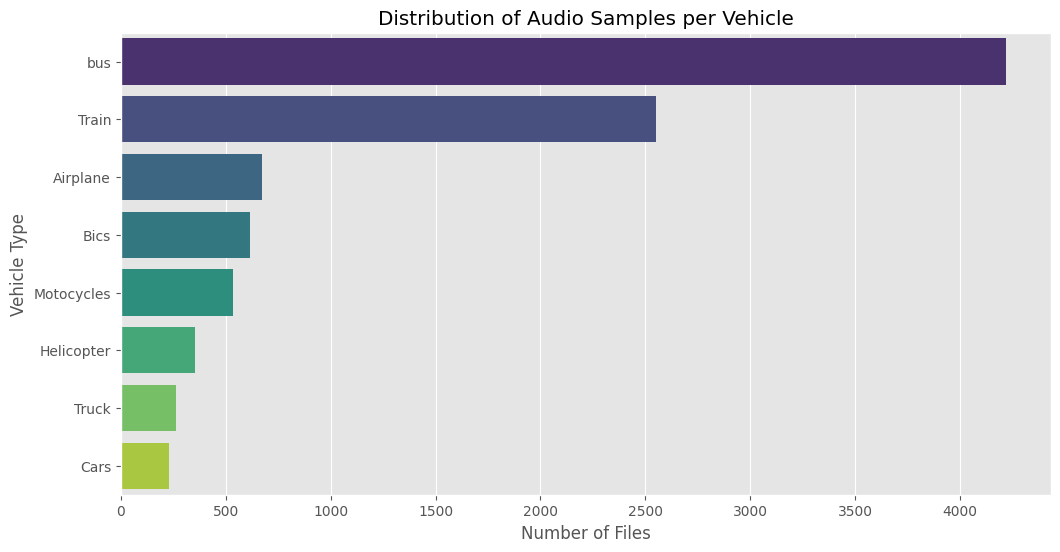

label
bus           4221
Train         2552
Airplane       673
Bics           617
Motocycles     537
Helicopter     353
Truck          265
Cars           230
Name: count, dtype: int64


In [7]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='label', order=df['label'].value_counts().index, palette='viridis')
plt.title('Distribution of Audio Samples per Vehicle')
plt.xlabel('Number of Files')
plt.ylabel('Vehicle Type')
plt.show()

print(df['label'].value_counts())

## **Take 1 Random Sample**

 SAMPLE DATA 
Label vehicle : Motocycles
Location File : vehicle_sound/Motocycles/BIKERS_100___Best_of_Superbikes_Sounds,_Wheelie_and_Burnout_Ultimate_Compilation_170.wav
Sampling Rate : 22050 Hz
total Sample : 110250
Duration : 5.00 detik
------------------------------
 LISTEN: Original Audio (Raw)


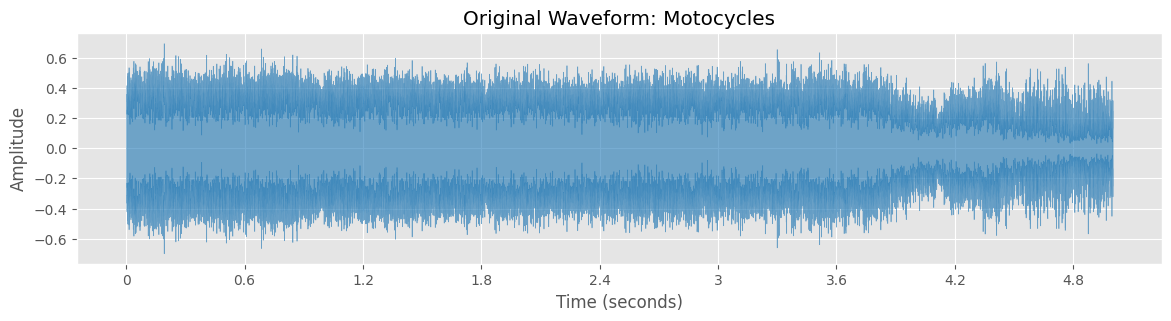

In [34]:
def load_audio(file_path, target_sr=22050):
    y, sr = librosa.load(file_path, sr=target_sr)
    return y, sr

def calculate_spectrum(signal, fs):
    N = len(signal)
    Y = fft(signal)
    freqs = fftfreq(N, 1/fs)
    half_N = N // 2
    return freqs[:half_N], np.abs(Y[:half_N])

sample_row = df.sample(1).iloc[0]
sample_path = sample_row['file_path']
sample_label = sample_row['label']

y_raw, sr = load_audio(sample_path)

print(f" SAMPLE DATA ")
print(f"Label vehicle : {sample_label}")
print(f"Location File : {sample_path}")
print(f"Sampling Rate : {sr} Hz")
print(f"total Sample : {len(y_raw)}")
print(f"Duration : {len(y_raw)/sr:.2f} detik")
print("-" * 30)

print(" LISTEN: Original Audio (Raw)")
ipd.display(ipd.Audio(y_raw, rate=sr))

plt.figure(figsize=(14, 3))
librosa.display.waveshow(y_raw, sr=sr, color='#1f77b4', alpha=0.6)
plt.title(f"Original Waveform: {sample_label}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()


Vehicle: Airplane
File Path: vehicle_sound/Airplane/12_BEST_SOUNDING_Take_offs___A350_A340_A380_B777_B787_A330___Melbourne_Airport_Plane_Spotting_064.wav
Sampling Rate: 22050 Hz
Duration: 5.00 seconds
Low Cutoff  (≈5% energy):  32.16 Hz
High Cutoff (≈95% energy): 2474.88 Hz


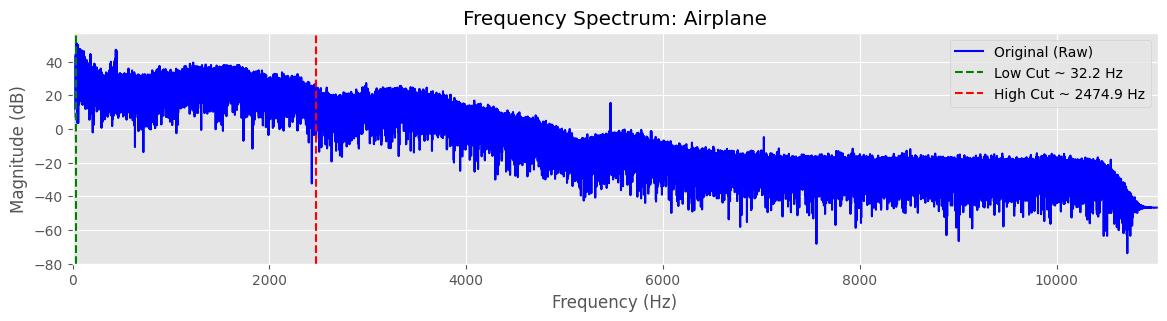


Vehicle: Bics
File Path: vehicle_sound/Bics/Elite_Cycling_Silcarbon_Racing_Card_Sound_Road_138.wav
Sampling Rate: 22050 Hz
Duration: 5.00 seconds
Low Cutoff  (≈5% energy):  56.80 Hz
High Cutoff (≈95% energy): 1694.40 Hz


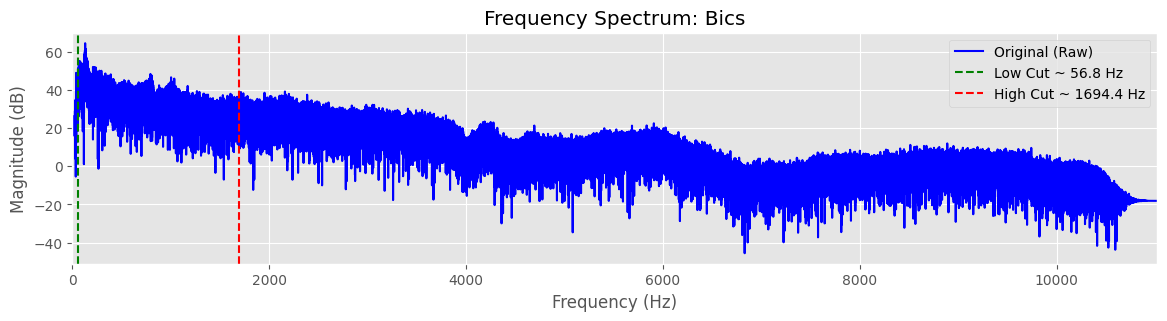


Vehicle: Cars
File Path: vehicle_sound/Cars/Street_Sounds____60min__Sleep_Video_107.wav
Sampling Rate: 22050 Hz
Duration: 5.00 seconds
Low Cutoff  (≈5% energy):  76.16 Hz
High Cutoff (≈95% energy): 2336.64 Hz


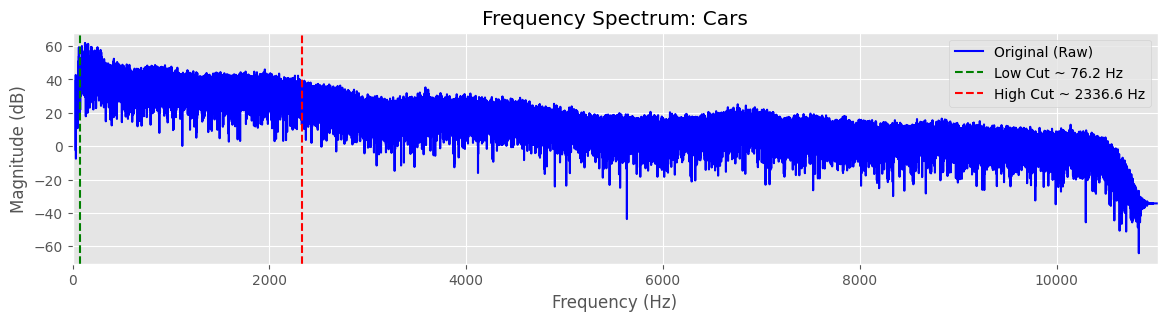


Vehicle: Helicopter
File Path: vehicle_sound/Helicopter/25th_Huey_Helicopter_no_music_21.wav
Sampling Rate: 22050 Hz
Duration: 5.00 seconds
Low Cutoff  (≈5% energy):  38.88 Hz
High Cutoff (≈95% energy): 1143.60 Hz


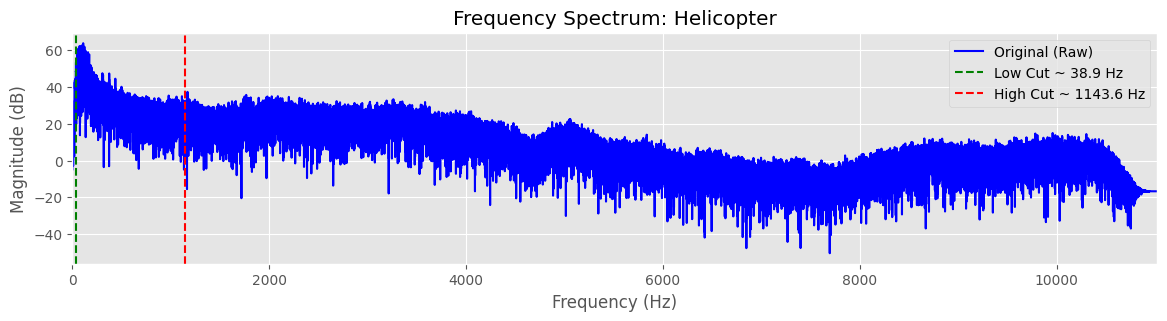


Vehicle: Motocycles
File Path: vehicle_sound/Motocycles/BIKERS_100___Best_of_Superbikes_Sounds,_Wheelie_and_Burnout_Ultimate_Compilation_124.wav
Sampling Rate: 22050 Hz
Duration: 5.00 seconds
Low Cutoff  (≈5% energy):  72.80 Hz
High Cutoff (≈95% energy): 2175.12 Hz


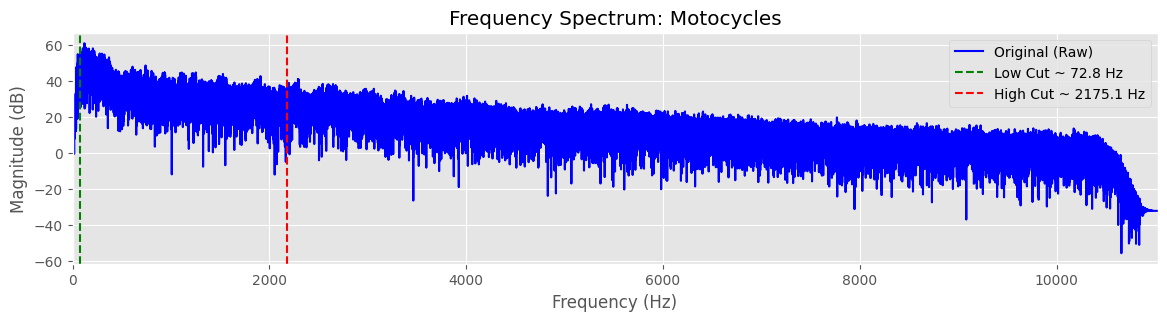


Vehicle: Train
File Path: vehicle_sound/Train/Train_sound_for_sleep_0105.wav
Sampling Rate: 22050 Hz
Duration: 5.00 seconds
Low Cutoff  (≈5% energy):  114.40 Hz
High Cutoff (≈95% energy): 1278.96 Hz


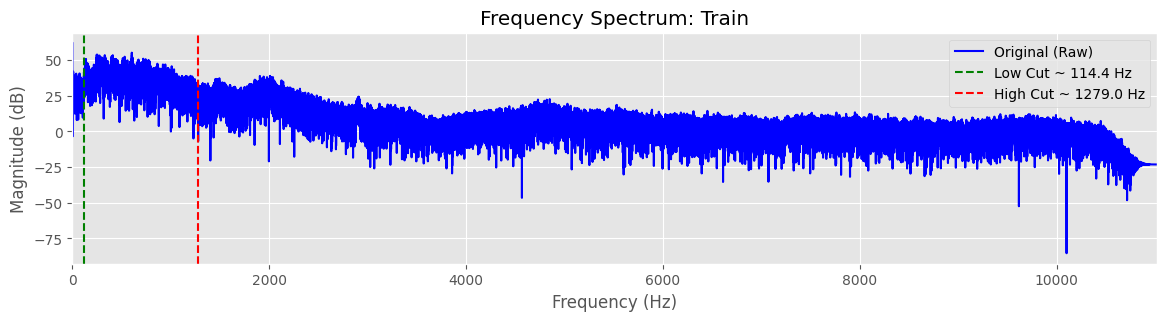


Vehicle: Truck
File Path: vehicle_sound/Truck/Best_Of_American_Trucks___Sound_025.wav
Sampling Rate: 22050 Hz
Duration: 5.00 seconds
Low Cutoff  (≈5% energy):  41.76 Hz
High Cutoff (≈95% energy): 462.96 Hz


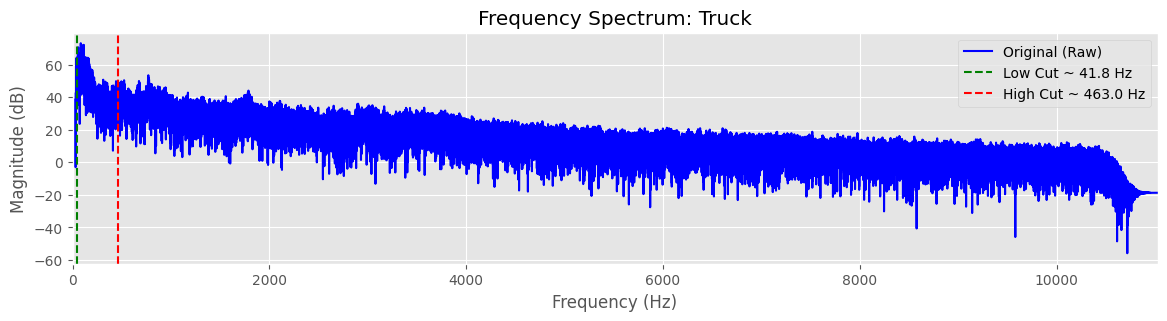


Vehicle: bus
File Path: vehicle_sound/bus/▶️_Bus_Sound_Effect._Bus_Ambience._Engine_White_Noise._Bus_White_Noise._12_Hours._🌏_6071.wav
Sampling Rate: 22050 Hz
Duration: 5.00 seconds
Low Cutoff  (≈5% energy):  58.72 Hz
High Cutoff (≈95% energy): 719.28 Hz


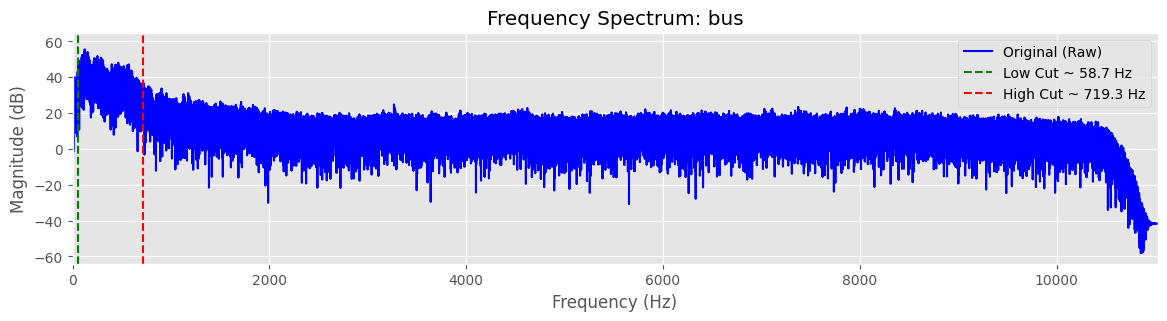


RECOMMENDED FILTER CONFIG BASED ON 1 SAMPLE EACH
Airplane : {'low': 32.160000000000004, 'high': 2474.88}
Bics : {'low': 56.800000000000004, 'high': 1694.3999999999999}
Cars : {'low': 76.16000000000001, 'high': 2336.64}
Helicopter : {'low': 38.88, 'high': 1143.6}
Motocycles : {'low': 72.8, 'high': 2175.12}
Train : {'low': 114.4, 'high': 1278.9599999999998}
Truck : {'low': 41.760000000000005, 'high': 462.96}
bus : {'low': 58.720000000000006, 'high': 719.28}


In [31]:
def cumulative_cutoff_freq(f, mag, percentile=0.95):
    power = mag**2
    cum = np.cumsum(power)
    cum = cum / cum[-1]
    idx = np.searchsorted(cum, percentile)
    idx = min(idx, len(f)-1)
    return f[idx]


sampled_df = df.groupby('label').sample(n=1)

recommended_filters = {}

for index, row in sampled_df.iterrows():
    sample_path = row['file_path']
    sample_label = row['label']

    y_raw, sr = load_audio(sample_path)

    print(f"\nVehicle: {sample_label}")
    print(f"File Path: {sample_path}")
    print(f"Sampling Rate: {sr} Hz")
    print(f"Duration: {len(y_raw)/sr:.2f} seconds")

    f_raw, mag_raw = calculate_spectrum(y_raw, sr)

    low5  = cumulative_cutoff_freq(f_raw, mag_raw, percentile=0.05)
    high95 = cumulative_cutoff_freq(f_raw, mag_raw, percentile=0.95)

    low_cut  = max(1.0, low5 * 0.8)
    high_cut = min(sr/2, high95 * 1.2)

    recommended_filters[sample_label] = {
        "low":  float(low_cut),
        "high": float(high_cut)
    }

    print(f"Low Cutoff  (≈5% energy):  {low_cut:.2f} Hz")
    print(f"High Cutoff (≈95% energy): {high_cut:.2f} Hz")

    plt.figure(figsize=(14, 3))
    plt.plot(f_raw, 20 * np.log10(mag_raw + 1e-6), label='Original (Raw)', color='blue')
    plt.axvline(low_cut, color='green', linestyle='--', label=f"Low Cut ~ {low_cut:.1f} Hz")
    plt.axvline(high_cut, color='red', linestyle='--', label=f"High Cut ~ {high_cut:.1f} Hz")
    plt.title(f"Frequency Spectrum: {sample_label}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.xlim(0, sr / 2)
    plt.grid(True)
    plt.legend()
    plt.show()

print("\nRECOMMENDED FILTER CONFIG BASED ON 1 SAMPLE EACH")
for lbl, flt in recommended_filters.items():
    print(f"{lbl} : {flt}")



Vehicle: Airplane
Low Cutoff (from recommended):  32.16 Hz
High Cutoff (from recommended): 2474.88 Hz


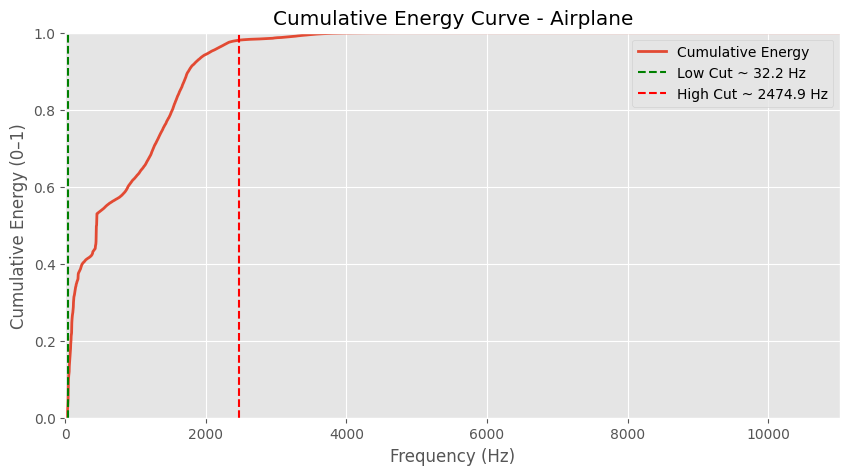


Vehicle: Bics
Low Cutoff (from recommended):  56.80 Hz
High Cutoff (from recommended): 1694.40 Hz


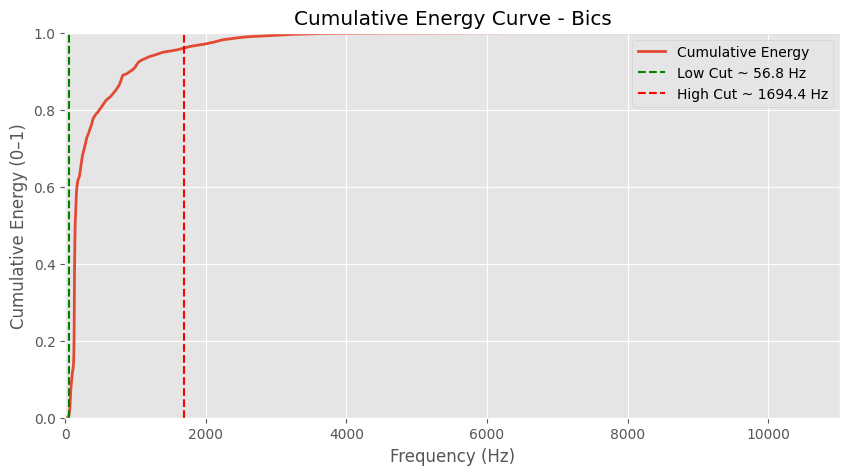


Vehicle: Cars
Low Cutoff (from recommended):  76.16 Hz
High Cutoff (from recommended): 2336.64 Hz


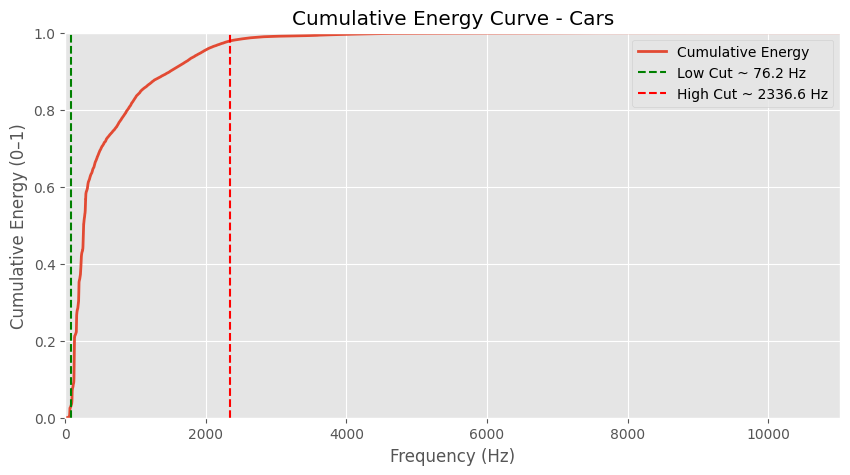


Vehicle: Helicopter
Low Cutoff (from recommended):  38.88 Hz
High Cutoff (from recommended): 1143.60 Hz


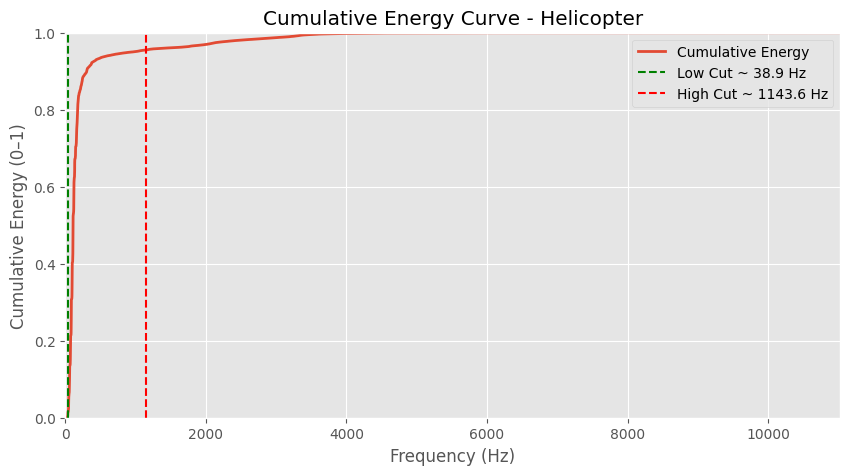


Vehicle: Motocycles
Low Cutoff (from recommended):  72.80 Hz
High Cutoff (from recommended): 2175.12 Hz


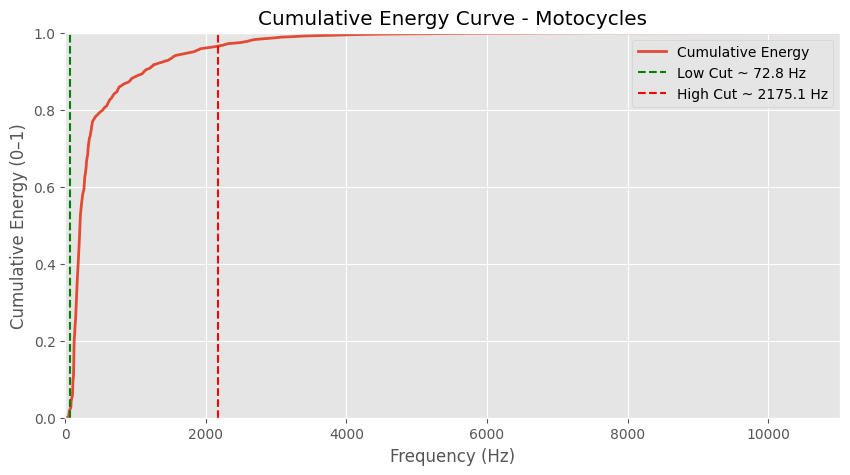


Vehicle: Train
Low Cutoff (from recommended):  114.40 Hz
High Cutoff (from recommended): 1278.96 Hz



Vehicle: Truck
Low Cutoff (from recommended):  41.76 Hz
High Cutoff (from recommended): 462.96 Hz


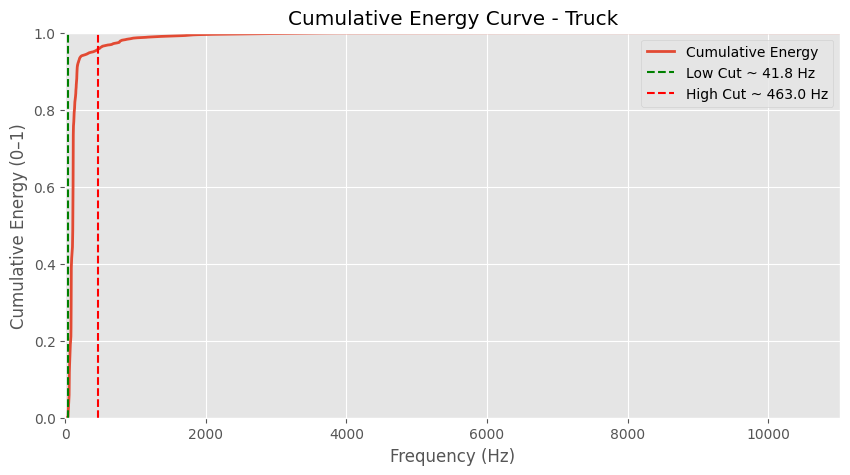


Vehicle: bus
Low Cutoff (from recommended):  58.72 Hz
High Cutoff (from recommended): 719.28 Hz


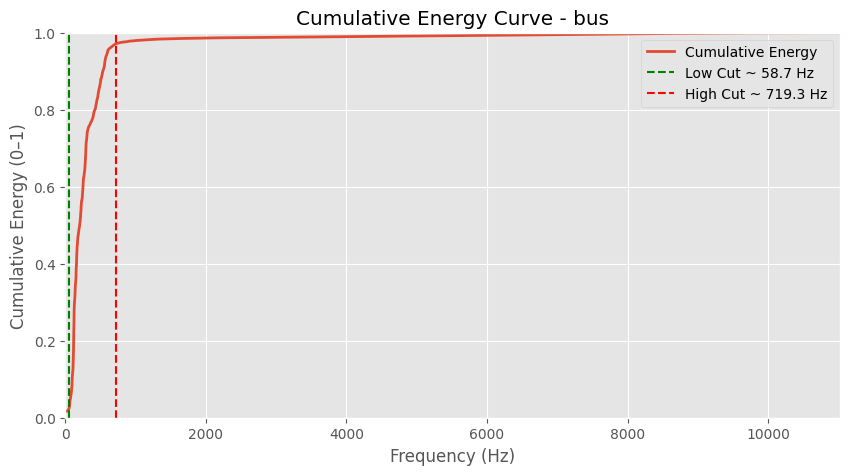

In [32]:
def cumulative_energy_curve(f, mag):
    power = mag**2
    cum = np.cumsum(power)
    cum = cum / cum[-1]
    return cum

for index, row in sampled_df.iterrows():
    sample_path = row['file_path']
    sample_label = row['label']

    y_raw, sr = load_audio(sample_path)

    f_raw, mag_raw = calculate_spectrum(y_raw, sr)

    cum = cumulative_energy_curve(f_raw, mag_raw)

    low_cut_recommended = recommended_filters[sample_label]['low']
    high_cut_recommended = recommended_filters[sample_label]['high']

    print(f"\nVehicle: {sample_label}")
    print(f"Low Cutoff (from recommended):  {low_cut_recommended:.2f} Hz")
    print(f"High Cutoff (from recommended): {high_cut_recommended:.2f} Hz")

    plt.figure(figsize=(10, 5))

    plt.plot(f_raw, cum, label="Cumulative Energy", linewidth=2)

    plt.axvline(low_cut_recommended, color='green', linestyle='--', label=f"Low Cut ~ {low_cut_recommended:.1f} Hz")
    plt.axvline(high_cut_recommended, color='red', linestyle='--', label=f"High Cut ~ {high_cut_recommended:.1f} Hz")

    plt.title(f"Cumulative Energy Curve - {sample_label}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Cumulative Energy (0–1)")
    plt.xlim(0, sr/2)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

##Calculate mean Freq all data

Calculating cutoff frequencies...
Calculated Cutoff Frequencies based on all data per label:
{'Helicopter': {'low': 54.400000000000006, 'high': 2692.6000000000004}, 'Airplane': {'low': 49.2, 'high': 576.2}, 'Cars': {'low': 62.6, 'high': 1866.0}, 'Train': {'low': 40.800000000000004, 'high': 993.6}, 'bus': {'low': 74.8, 'high': 569.6}, 'Motocycles': {'low': 68.60000000000001, 'high': 2237.2000000000003}, 'Bics': {'low': 87.4, 'high': 6069.0}, 'Truck': {'low': 63.0, 'high': 1623.0}}
Generating cumulative energy curves...


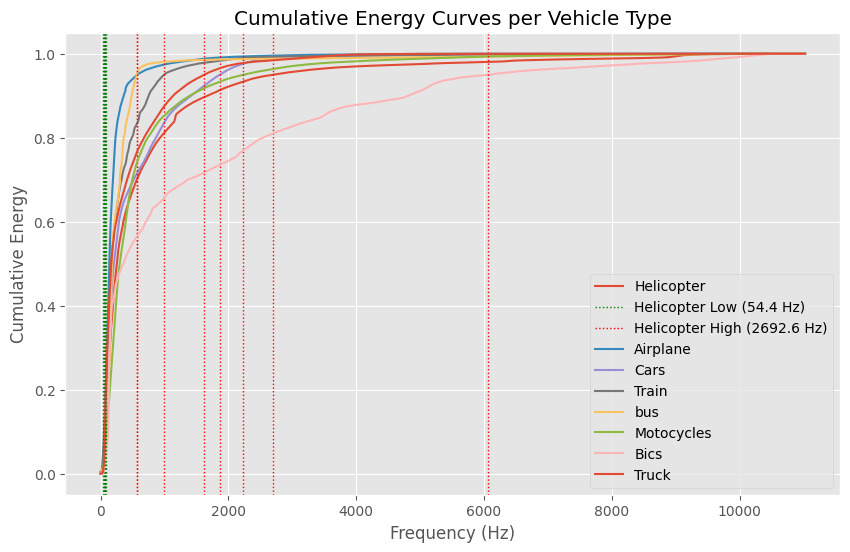

In [11]:
def compute_cutoff_for_label(samples, freqs, low_pct=0.05, high_pct=0.95):
    all_energy = []

    for s in samples:
        energy = np.abs(s)**2
        all_energy.append(energy)

    mean_energy = np.mean(all_energy, axis=0)

    cumulative = np.cumsum(mean_energy)
    cumulative /= cumulative[-1]
    low_idx = np.where(cumulative >= low_pct)[0][0]
    high_idx = np.where(cumulative >= high_pct)[0][0]

    return freqs[low_idx], freqs[high_idx], cumulative

def visualize_cumulative_curves(data_dict, freqs):
    plt.figure(figsize=(10, 6))

    for label, samples in data_dict.items():
        low, high, cumulative = compute_cutoff_for_label(samples, freqs)
        plt.plot(freqs, cumulative, label=label)

        plt.axvline(low, color='green', linestyle=':', linewidth=1, label=f'{label} Low ({low:.1f} Hz)' if label == list(data_dict.keys())[0] else None)
        plt.axvline(high, color='red', linestyle=':', linewidth=1, label=f'{label} High ({high:.1f} Hz)' if label == list(data_dict.keys())[0] else None)

    plt.title("Cumulative Energy Curves per Vehicle Type")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Cumulative Energy")
    plt.grid(True)
    plt.legend()
    plt.show()

data_dict = defaultdict(list)
freqs = None
FIXED_DURATION_SEC = 5

for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Collecting spectra for all labels"):
    file_path = row['file_path']
    label = row['label']

    try:
        y, sr_local = librosa.load(file_path, sr=22050)
        target_samples = sr_local * FIXED_DURATION_SEC
        if len(y) < target_samples:
            y = np.pad(y, (0, target_samples - len(y)), 'constant')
        elif len(y) > target_samples:
            y = y[:target_samples]

        f_raw, mag_raw = calculate_spectrum(y, sr_local)

        if freqs is None:
            freqs = f_raw

        data_dict[label].append(mag_raw)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

cutoffs = {}

print("Calculating cutoff frequencies...")
for label, samples in data_dict.items():
    low, high, _ = compute_cutoff_for_label(samples, freqs)
    cutoffs[label] = {"low": float(low), "high": float(high)}

print("Calculated Cutoff Frequencies based on all data per label:")
print(cutoffs)

print("Generating cumulative energy curves...")
visualize_cumulative_curves(data_dict, freqs)


## **Filter Digital**

FILTER_CONFIG dictionary defined.
Filter Range: 120 Hz - 10000 Hz
LISTEN: Audio After Filter


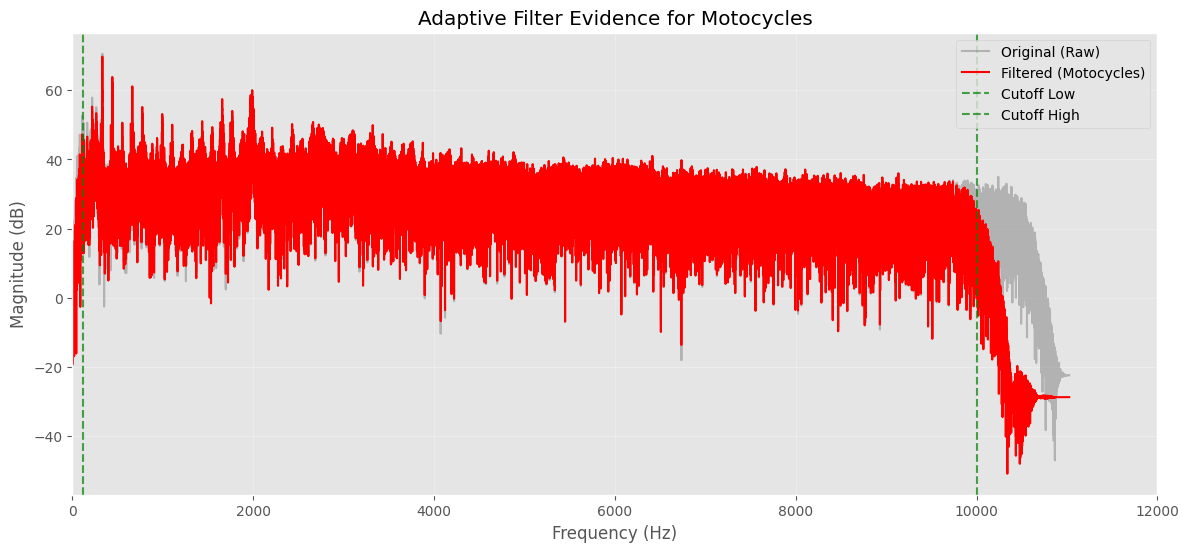

In [35]:
FILTER_CONFIG = {
    'bus': {'low': 40, 'high': 8000},
    'Train': {'low': 100, 'high': 8000},
    'Truck': {'low': 40, 'high': 7500},
    'Cars': {'low': 80, 'high': 8000},
    'Motocycles': {'low': 120, 'high': 10000},
    'Bics': {'low': 10, 'high': 3000},
    'Airplane': {'low': 100, 'high': 10000},
    'Helicopter': {'low': 20, 'high': 9000},
    'default' : {'low': 10, 'high': 10000}
}
print("FILTER_CONFIG dictionary defined.")

def get_filter_taps(sample_label, fs, num_taps=101):

    key_found = 'default'
    if isinstance(sample_label, str):
        label_lower = sample_label.lower()
        for key in FILTER_CONFIG:
            if key.lower() in label_lower:
                key_found = key
                break

    config = FILTER_CONFIG[key_found]

    low_freq = config['low']
    high_freq = config['high']

    nyquist = 0.5 * fs
    norm_low = low_freq / nyquist
    norm_high = high_freq / nyquist

    if norm_high >= 1.0: norm_high = 0.99

    taps = sig.firwin(num_taps, [norm_low, norm_high], pass_zero=False)

    return taps, low_freq, high_freq

def apply_filter_function(signal, taps):
    return sig.lfilter(taps, 1.0, signal)

h_adaptive, f_low, f_high = get_filter_taps(sample_label, sr)

y_bandpass_filtered = apply_filter_function(y_raw, h_adaptive)
print(f"Filter Range: {f_low} Hz - {f_high} Hz")
print("LISTEN: Audio After Filter")
ipd.display(ipd.Audio(y_bandpass_filtered, rate=sr))

def calculate_spectrum(signal, fs):
    N = len(signal)
    Y = fft(signal)
    freqs = fftfreq(N, 1/fs)
    half_N = N // 2
    return freqs[:half_N], np.abs(Y[:half_N])

f_raw, mag_raw = calculate_spectrum(y_raw, sr)
f_filt, mag_filt = calculate_spectrum(y_bandpass_filtered, sr)

plt.figure(figsize=(14, 6))
plt.plot(f_raw, 20*np.log10(mag_raw + 1e-6), label='Original (Raw)', alpha=0.5, color='gray')
plt.plot(f_filt, 20*np.log10(mag_filt + 1e-6), label=f'Filtered ({sample_label})', color='red', linewidth=1.5)

plt.axvline(f_low, color='green', linestyle='--', alpha=0.7, label='Cutoff Low')
plt.axvline(f_high, color='green', linestyle='--', alpha=0.7, label='Cutoff High')

plt.title(f"Adaptive Filter Evidence for {sample_label}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend(loc='upper right')
plt.xlim(0, 12000)
plt.grid(True, which='both', alpha=0.3)
plt.show()

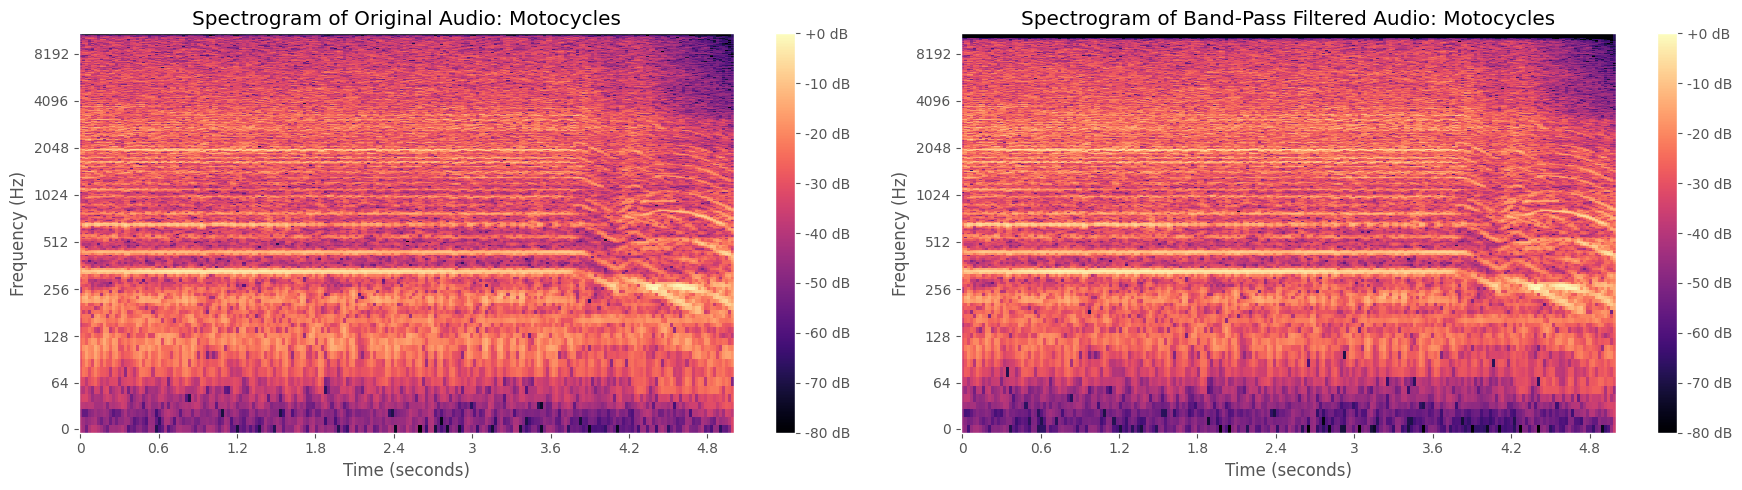

In [36]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_raw)), ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram of Original Audio: {sample_label}')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_bandpass_filtered)), ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram of Band-Pass Filtered Audio: {sample_label}')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

LISTEN: Audio After Filter


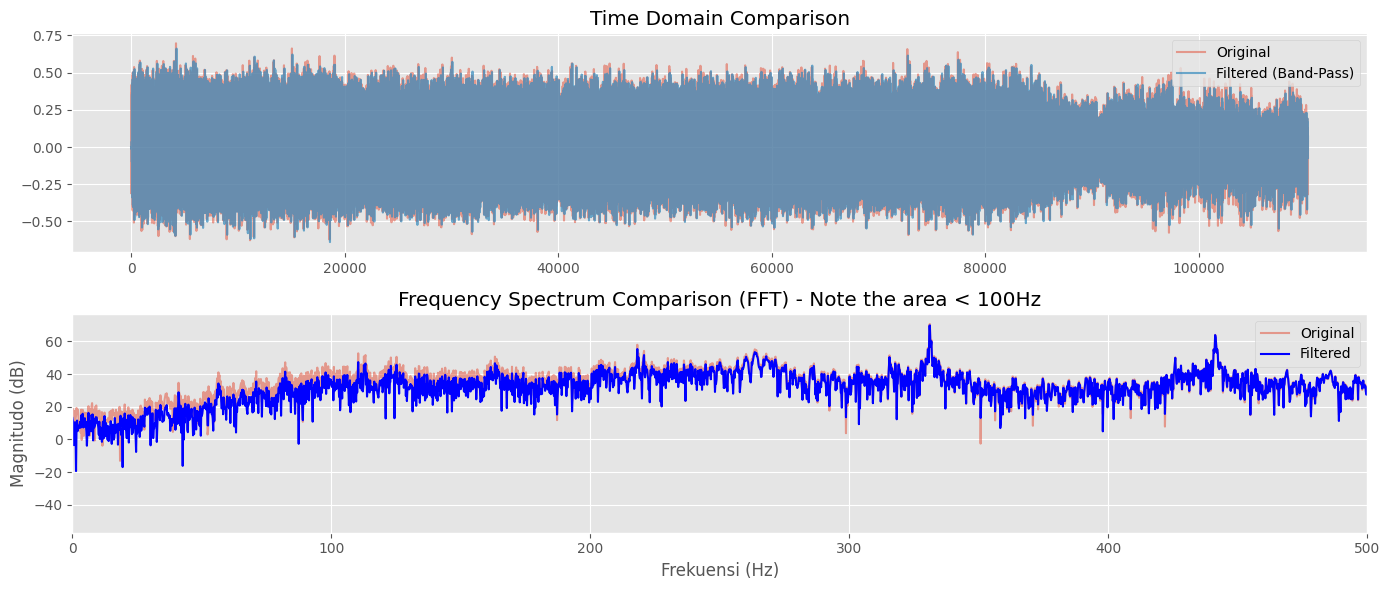

In [47]:
def apply_filter_function(signal, filter_taps):
    return sig.lfilter(filter_taps, 1.0, signal)

y_filtered = apply_filter_function(y_raw, h_adaptive)

print("LISTEN: Audio After Filter")
ipd.display(ipd.Audio(y_filtered, rate=sr))

f_raw, mag_raw = calculate_spectrum(y_raw, sr)
f_filt, mag_filt = calculate_spectrum(y_filtered, sr)

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(y_raw, label='Original', alpha=0.5)
plt.plot(y_filtered, label='Filtered (Band-Pass)', alpha=0.7)
plt.title("Time Domain Comparison")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(f_raw, 20*np.log10(mag_raw + 1e-6), label='Original', alpha=0.5)
plt.plot(f_filt, 20*np.log10(mag_filt + 1e-6), label='Filtered', color='blue')
plt.title("Frequency Spectrum Comparison (FFT) - Note the area < 100Hz")
plt.xlabel("Frekuensi (Hz)")
plt.ylabel("Magnitudo (dB)")
plt.xlim(0, 500)
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
def apply_fft_bandpass_filter(signal, sr, low_freq, high_freq):
    N = len(signal)
    T = 1.0 / sr

    yf = fft(signal)
    xf = fftfreq(N, T)

    yf_filtered = np.copy(yf)

    mask = (np.abs(xf) >= low_freq) & (np.abs(xf) <= high_freq)
    yf_filtered[~mask] = 0

    filtered_signal = np.real(np.fft.ifft(yf_filtered))

    return filtered_signal

print("Function 'apply_fft_bandpass_filter' defined.")

Function 'apply_fft_bandpass_filter' defined.


## **Extraction Feature**

In [51]:
def extract_advanced_features(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    centroid_mean = np.mean(centroid)

    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff_mean = np.mean(rolloff)

    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)

    features = np.hstack([mfcc_mean, centroid_mean, rolloff_mean, zcr_mean])

    return features

def process_file_advanced(file_path, label_hint='default', apply_filter=True, apply_fft_filter=False):
    try:
        y, sr = librosa.load(file_path, sr=22050)

        if apply_filter:
            filter_taps, low_freq, high_freq = get_filter_taps(label_hint, sr)
            y_clean = apply_filter_function(y, filter_taps)
            if apply_fft_filter:
                y_clean = apply_fft_bandpass_filter(y_clean, sr, low_freq, high_freq)
        else:
            y_clean = y
            if apply_fft_filter:
                filter_taps_dummy, low_freq, high_freq = get_filter_taps(label_hint, sr)
                y_clean = apply_fft_bandpass_filter(y_clean, sr, low_freq, high_freq)

        feature_vector = extract_advanced_features(y_clean, sr)

        return feature_vector

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

print("Advanced feature extraction function (MFCC + Centroid + Rolloff + ZCR) ")


Advanced feature extraction function (MFCC + Centroid + Rolloff + ZCR) 


Demonstrating double filtering with sample: Motocycles
FIR Filter applied: 120 Hz - 10000 Hz
FFT Bandpass Filter applied on top of FIR filter, with range: 120 Hz - 10000 Hz
Original Audio:


Audio after FIR Filter:


Audio after FIR + FFT Filters:


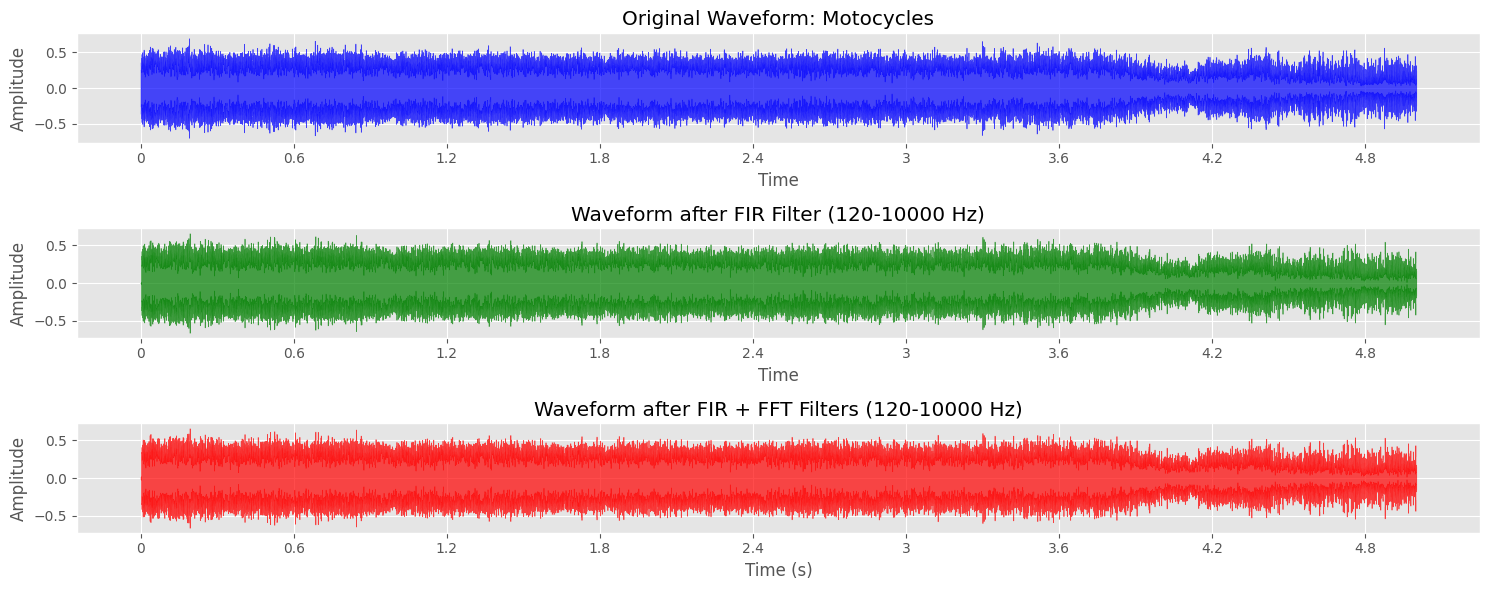

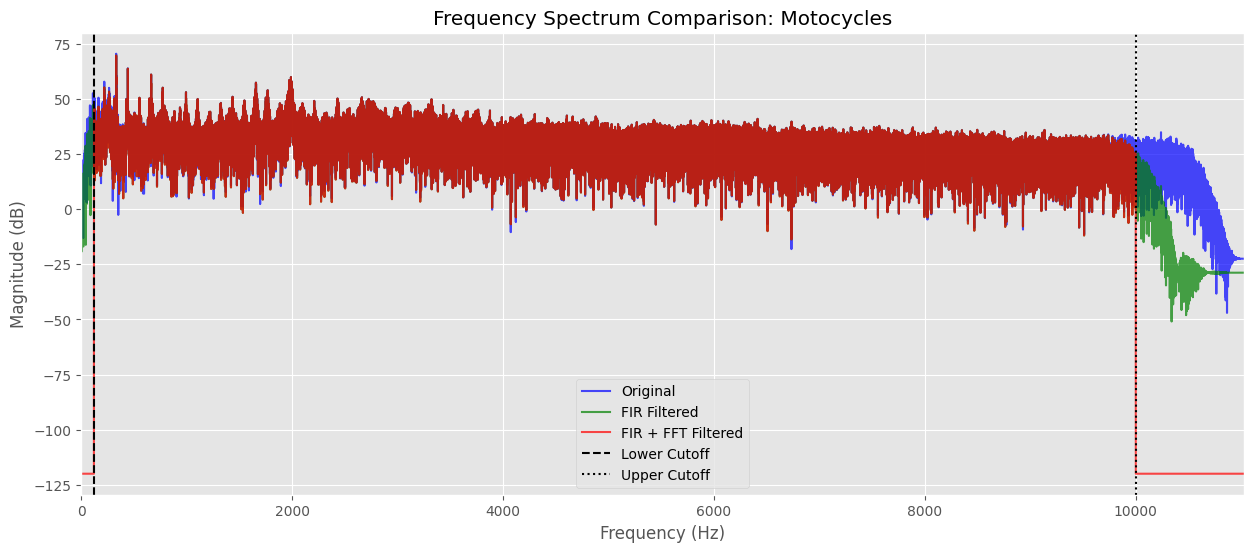

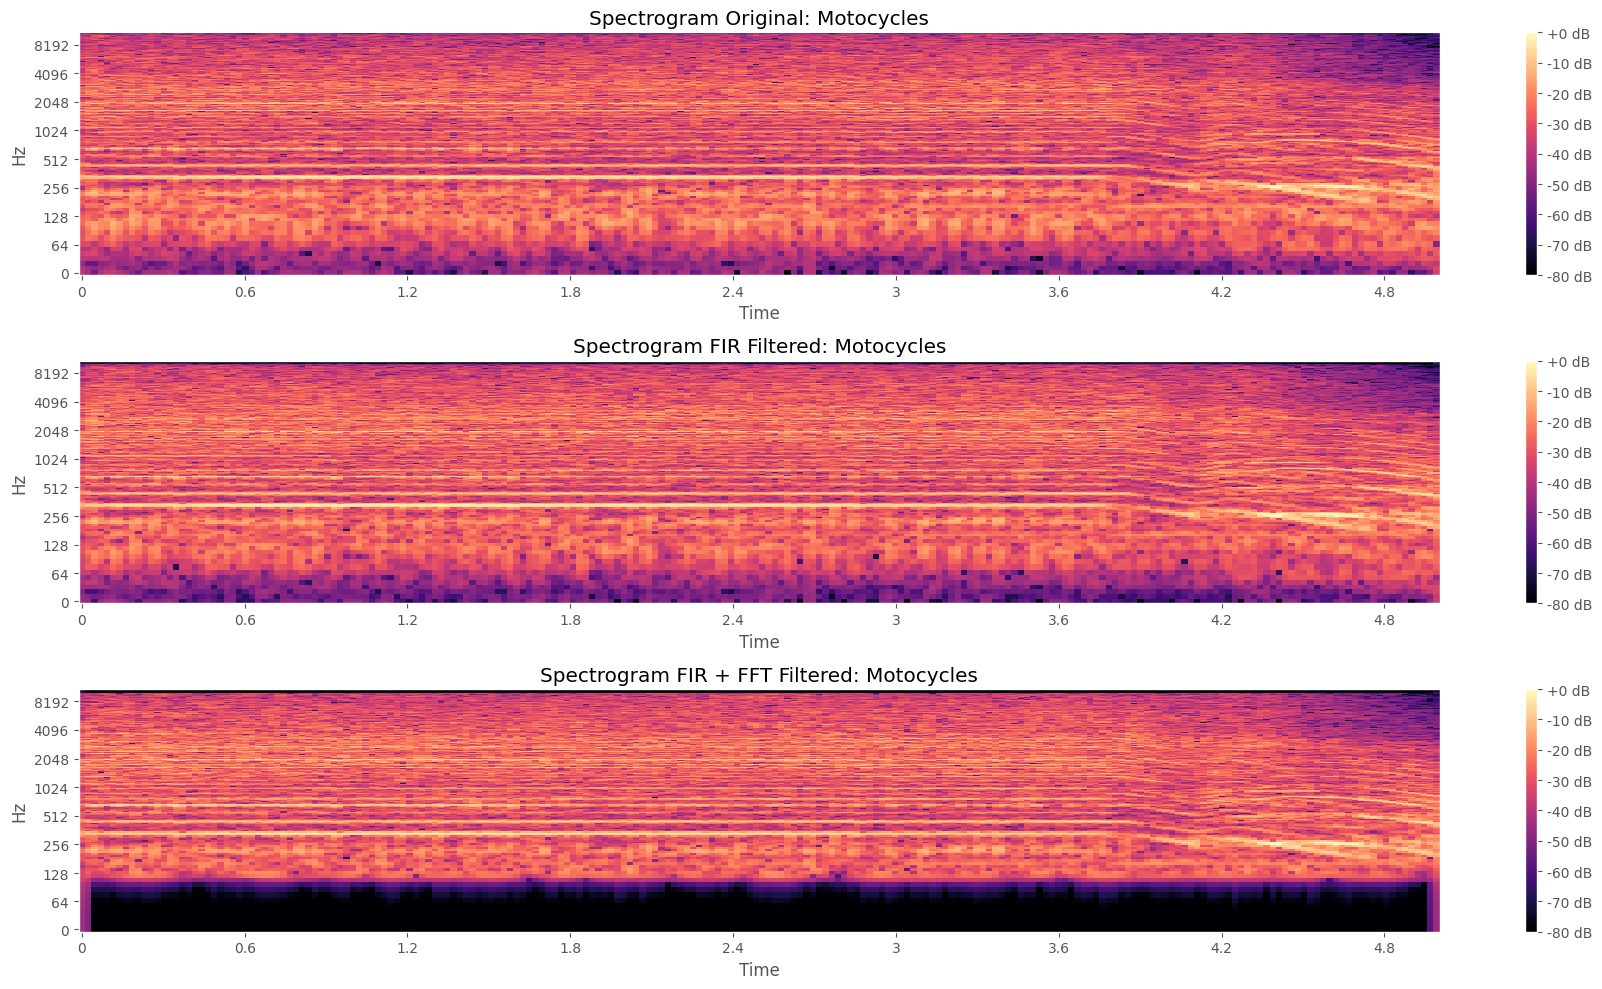

In [54]:
print(f"Demonstrating double filtering with sample: {sample_label}")

y_fir_filtered = apply_filter_function(y_raw, h_adaptive)
print(f"FIR Filter applied: {f_low} Hz - {f_high} Hz")

y_double_filtered = apply_fft_bandpass_filter(y_fir_filtered, sr, f_low, f_high)
print(f"FFT Bandpass Filter applied on top of FIR filter, with range: {f_low} Hz - {f_high} Hz")

print("Original Audio:")
ipd.display(ipd.Audio(y_raw, rate=sr))

print("Audio after FIR Filter:")
ipd.display(ipd.Audio(y_fir_filtered, rate=sr))

print("Audio after FIR + FFT Filters:")
ipd.display(ipd.Audio(y_double_filtered, rate=sr))

plt.figure(figsize=(15, 6))
plt.subplot(3, 1, 1)
librosa.display.waveshow(y_raw, sr=sr, color='blue', alpha=0.7)
plt.title(f'Original Waveform: {sample_label}')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
librosa.display.waveshow(y_fir_filtered, sr=sr, color='green', alpha=0.7)
plt.title(f'Waveform after FIR Filter ({f_low}-{f_high} Hz)')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
librosa.display.waveshow(y_double_filtered, sr=sr, color='red', alpha=0.7)
plt.title(f'Waveform after FIR + FFT Filters ({f_low}-{f_high} Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

f_raw_spec, mag_raw_spec = calculate_spectrum(y_raw, sr)
f_fir_spec, mag_fir_spec = calculate_spectrum(y_fir_filtered, sr)
f_double_spec, mag_double_spec = calculate_spectrum(y_double_filtered, sr)

plt.figure(figsize=(15, 6))
plt.plot(f_raw_spec, 20 * np.log10(mag_raw_spec + 1e-6), label='Original', color='blue', alpha=0.7)
plt.plot(f_fir_spec, 20 * np.log10(mag_fir_spec + 1e-6), label='FIR Filtered', color='green', alpha=0.7)
plt.plot(f_double_spec, 20 * np.log10(mag_double_spec + 1e-6), label='FIR + FFT Filtered', color='red', alpha=0.7)
plt.axvline(f_low, color='black', linestyle='--', label='Lower Cutoff')
plt.axvline(f_high, color='black', linestyle=':', label='Upper Cutoff')
plt.title(f'Frequency Spectrum Comparison: {sample_label}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, sr / 2)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 10))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_raw)), ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram Original: {sample_label}')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_fir_filtered)), ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram FIR Filtered: {sample_label}')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_double_filtered)), ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram FIR + FFT Filtered: {sample_label}')

plt.tight_layout()
plt.show()

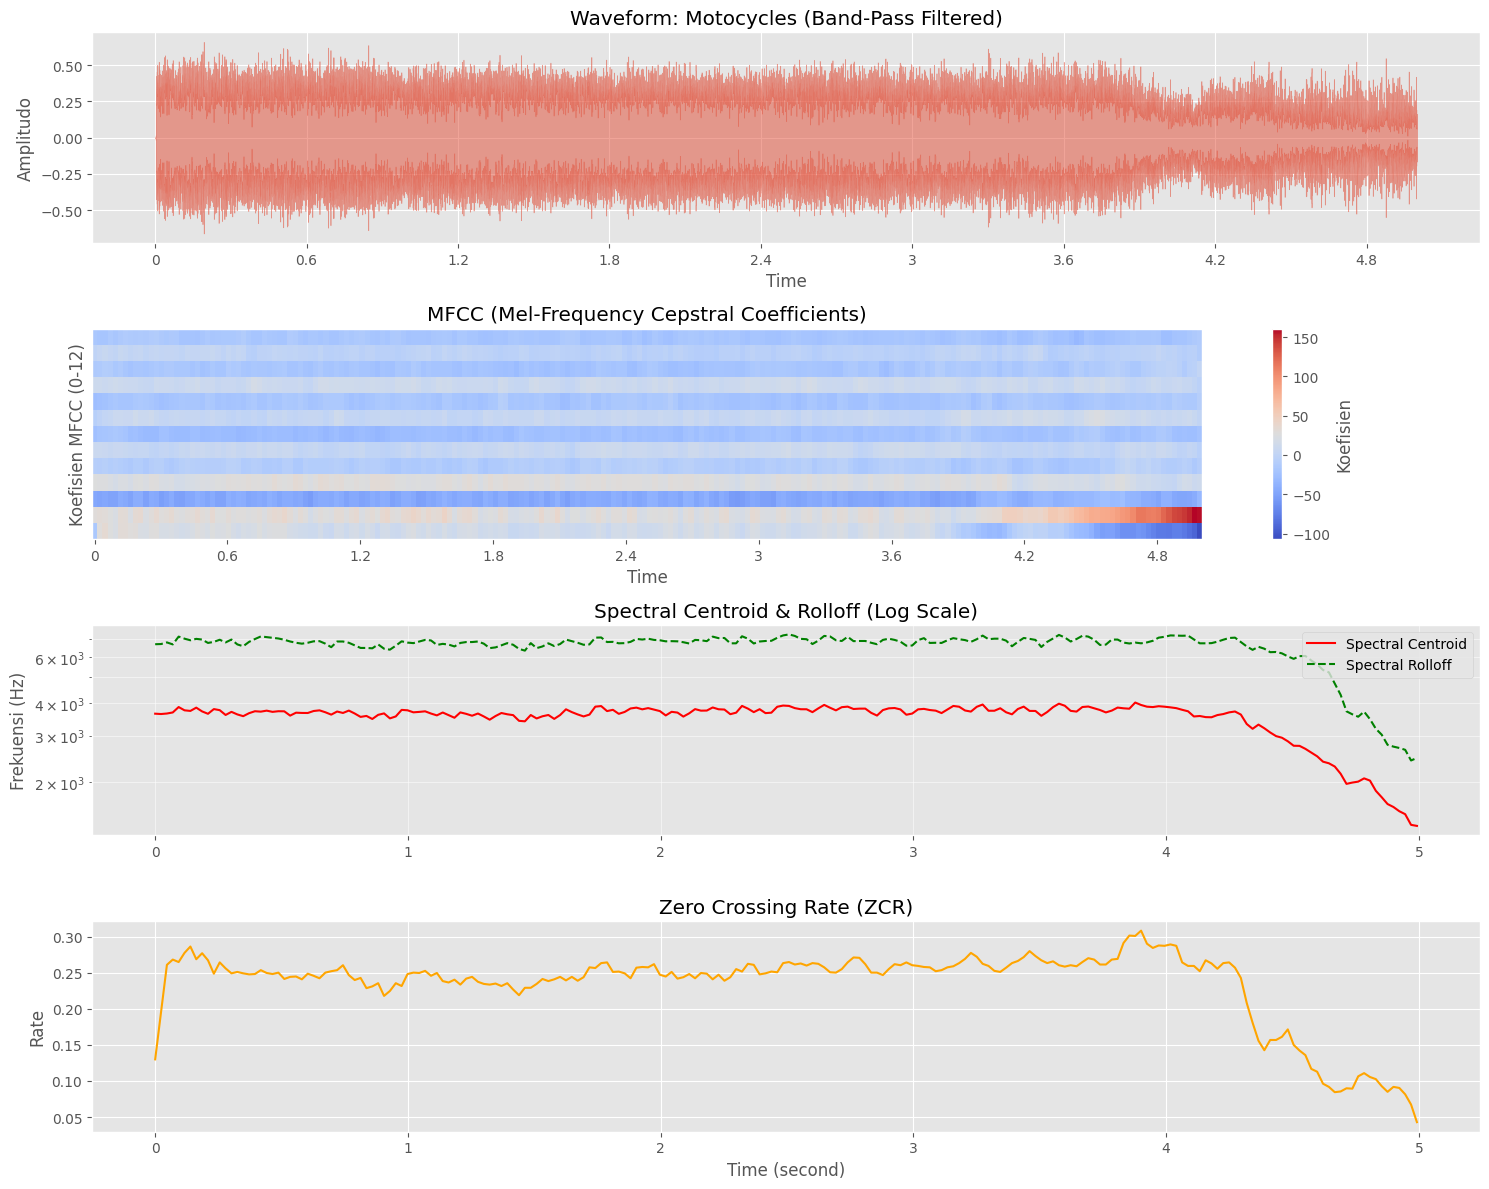

 STATISTIK FITUR (Motocycles) 
AVG Centroid : 3520.38 Hz
AVG Rolloff  : 6560.95 Hz
AVG ZCR      : 0.2347


In [52]:
def extract_features_visualize(y, sr):

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)

    zcr = librosa.feature.zero_crossing_rate(y)

    return mfcc, centroid, rolloff, zcr
mfcc, centroid, rolloff, zcr = extract_features_visualize(y_bandpass_filtered, sr)

times = librosa.times_like(centroid, sr=sr)

plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
librosa.display.waveshow(y_bandpass_filtered, sr=sr, alpha=0.5)
plt.title(f'Waveform: {sample_label} (Band-Pass Filtered)')
plt.ylabel('Amplitudo')

plt.subplot(4, 1, 2)
librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap='coolwarm')
plt.colorbar(label='Koefisien')
plt.title('MFCC (Mel-Frequency Cepstral Coefficients)')
plt.ylabel('Koefisien MFCC (0-12)')

plt.subplot(4, 1, 3)

plt.semilogy(times, centroid[0], label='Spectral Centroid', color='r')
plt.semilogy(times, rolloff[0], label='Spectral Rolloff', color='g', linestyle='--')
plt.title('Spectral Centroid & Rolloff (Log Scale)')
plt.ylabel('Frekuensi (Hz)')
plt.legend(loc='upper right')
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.subplot(4, 1, 4)
plt.plot(times, zcr[0], label='ZCR', color='orange')
plt.title('Zero Crossing Rate (ZCR)')
plt.ylabel('Rate')
plt.xlabel('Time (second)')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f" STATISTIK FITUR ({sample_label}) ")
print(f"AVG Centroid : {np.mean(centroid):.2f} Hz")
print(f"AVG Rolloff  : {np.mean(rolloff):.2f} Hz")
print(f"AVG ZCR      : {np.mean(zcr):.4f}")

In [73]:
X_features = []
y_labels = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    path = row['file_path']
    label = row['label']

    feature_vector = process_file_advanced(path, label_hint=label)

    if feature_vector is not None:
        X_features.append(feature_vector)
        y_labels.append(label)

X = np.array(X_features)
y = np.array(y_labels)

print(f"\nExtraction Complete!")
print(f"Feature Data Dimension (X): {X.shape}")
print(f"Label Dimension (y): {y.shape}")

print(f"Number of features per audio: {X.shape[1]}")

100%|██████████| 9448/9448 [13:48<00:00, 11.41it/s]


Extraction Complete!
Feature Data Dimension (X): (9448, 16)
Label Dimension (y): (9448,)
Number of features per audio: 16


In [74]:
df_features = pd.DataFrame(X)
df_features['label'] = y_labels

feature_names = [f'mfcc_{i+1}' for i in range(13)] + ['centroid', 'rolloff', 'zcr']
df_features.columns = feature_names + ['label']

mean_features_per_class = df_features.groupby('label').mean()

print("Average Features per Class:")
display(mean_features_per_class)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    ax = axes[i]
    mean_features_per_class[feature].sort_values(ascending=False).plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'AVG{feature}')
    ax.set_xlabel('')
    ax.set_ylabel('AVG Value')
    ax.tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Average Comparison of Audio Features per Vehicle Class', y=1.02, fontsize=18)
plt.show()

Average Features per Class:


mfcc_1      mfcc_2      mfcc_3     mfcc_4     mfcc_5  \
label                                                                  
Airplane   -203.837227  203.159883   -5.874062  31.125408   5.625908   
Bics       -348.989088  264.596004 -108.865543 -10.511955  69.517717   
Cars       -155.780795  183.650263  -65.355801  36.673180 -17.710996   
Helicopter -130.950304  145.748164  -39.620252  40.610078 -11.903981   
Motocycles -114.372379  114.276496  -29.400507  22.093705 -15.469509   
Train      -138.510399  185.476196  -38.355858  18.859658 -34.861024   
Truck       -86.582046  189.250398  -66.799401  47.764857 -22.983335   
bus        -180.434315  148.104123    4.560950  61.010132 -28.195214   

               mfcc_6     mfcc_7     mfcc_8     mfcc_9    mfcc_10    mfcc_11  \
label                                                                          
Airplane     7.990360   1.827283   4.855067  -2.982064   4.801148  -5.526049   
Bics       -34.668795 -19.285347  35.629543 -12.931243 -17.569548  23.374485   
Cars        26.831162 -19.579424  14.490000  -6.125002   8.440960 -10.879190   
Helicopter  24.462087 -14.889295  18.575130 -13.720145  13.211700 -15.123058   
Motocycles   8.356781 -18.544884   3.491183 -15.298801   1.697259 -12.246630   
Train       16.657807 -41.504493  11.041108  -5.862674  -2.896802 -11.595545   
Truck       19.779942  -3.646969   6.354230  -4.993518   6.814071  -0.293514   
bus         38.968464 -29.921212  15.837849 -24.591625  10.593647 -11.206518   

              mfcc_12    mfcc_13     centroid      rolloff       zcr  
label                                                                 
Airplane     1.946888  -1.717499   786.125933  1323.076222  0.039966  
Bics        -5.908591 -15.949059  1391.503060  2390.233386  0.117263  
Cars         2.889611  -2.110589  1317.461458  2350.028659  0.079245  
Helicopter  10.620123 -11.110622  1736.535774  3589.794110  0.097429  
Motocycles   1.667779 -10.802958  1983.516547  4029.014356  0.090184  
Train       -3.540298  -3.896536  1182.211895  2172.939391  0.063722  
Truck       -6.316266   9.650852  1270.379000  2528.660111  0.068779  
bus          4.237625   1.789350  1443.444494  3745.861209  0.051636

## **Model Classification**

In [75]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
classes = encoder.classes_
print(f"Class detected: {classes}")

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
print("Training Done")

y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Model: {acc*100:.2f}%")

Class detected: ['Airplane' 'Bics' 'Cars' 'Helicopter' 'Motocycles' 'Train' 'Truck' 'bus']
Training Done

Accuracy Model: 98.52%


In [76]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix: Classification Vehicle')
plt.ylabel('Original Label')
plt.xlabel('Model Prediction')
plt.show()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    Airplane       0.95      0.92      0.94       135
        Bics       1.00      1.00      1.00       123
        Cars       0.98      0.96      0.97        46
  Helicopter       1.00      0.87      0.93        71
  Motocycles       0.93      0.97      0.95       107
       Train       0.98      1.00      0.99       511
       Truck       0.98      0.98      0.98        53
         bus       1.00      1.00      1.00       844

    accuracy                           0.99      1890
   macro avg       0.98      0.96      0.97      1890
weighted avg       0.99      0.99      0.99      1890



## **Classification New File**

 CLASSIFICATION SYSTEM TRIAL 


Saving bobber-motorcycle-409408.mp3 to bobber-motorcycle-409408.mp3

Processing file: bobber-motorcycle-409408.mp3...
Result Detection: MOTOCYCLES
Confident: 87.00%
Highest Probability:
 - Motocycles: 87.00%
 - Airplane: 10.00%
 - Helicopter: 3.00%

 Play Audio:


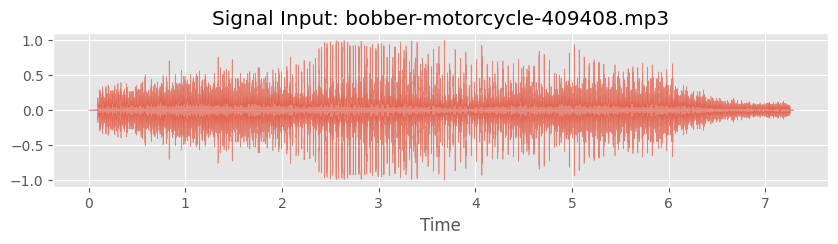

In [84]:
def classify_uploaded_file():
    print(" CLASSIFICATION SYSTEM TRIAL ")

    uploaded = files.upload()

    for fn in uploaded.keys():
        path = fn
        print(f"\nProcessing file: {fn}...")

        features = process_file_advanced(path, label_hint='default', apply_filter=True)

        if features is not None:
            features_scaled = scaler.transform([features])

            probs = model.predict_proba(features_scaled)[0]
            pred_idx = np.argmax(probs)
            pred_label = classes[pred_idx]
            confidence = probs[pred_idx] * 100

            print(f"Result Detection: {pred_label.upper()}")
            print(f"Confident: {confidence:.2f}%")

            top3_idx = probs.argsort()[-3:][::-1]
            print("Highest Probability:")
            for idx in top3_idx:
                print(f" - {classes[idx]}: {probs[idx]*100:.2f}%")

            print("\n Play Audio:")
            y, sr = librosa.load(path, sr=22050)
            ipd.display(ipd.Audio(y, rate=sr))

            plt.figure(figsize=(10, 2))
            librosa.display.waveshow(y, sr=sr, alpha=0.6)
            plt.title(f"Signal Input: {fn}")
            plt.show()

        else:
            print("Failed")

classify_uploaded_file()